# BinWaves example in Cantabria (Reconstruction)

**In this notebook**: 
<br><br>
Here waves are reconstructed at the buoy location for comparison.
<br><br>
Steps:
- Buoy is loaded.
- Kp propagation coefficients and hindcast reconstruction is made at the buoy location.
- Comparison plots and statistics are shown.

In [1]:
import xarray as xr
from bluemath_tk.core.operations import convert_utm_to_lonlat

# Load all the gridded kps

kp_coeffs = xr.open_dataset("outputs/kp_coeffs_gridded.nc").rename({"case": "case_num"})
kp_coeffs["utm_x"], kp_coeffs["utm_y"] = convert_utm_to_lonlat(
    kp_coeffs.utm_x, kp_coeffs.utm_y, projection="SPAIN"
)
kp_coeffs

<xarray.Dataset> Size: 33GB
Dimensions:   (utm_y: 71, utm_x: 120, case_num: 696, freq: 29, dir: 24)
Coordinates:
  * case_num  (case_num) int64 6kB 0 1 2 3 4 5 6 ... 689 690 691 692 693 694 695
  * dir       (dir) float64 192B 7.5 22.5 37.5 52.5 ... 307.5 322.5 337.5 352.5
  * freq      (freq) float32 116B 0.035 0.0385 0.04235 ... 0.4171 0.4589 0.5047
  * utm_x     (utm_x) float64 960B -3.987 -3.981 -3.975 ... -3.263 -3.257 -3.251
  * utm_y     (utm_y) float64 568B 43.37 43.37 43.38 43.38 ... 43.68 43.68 43.69
Data variables:
    kp        (utm_y, utm_x, case_num, freq, dir) float64 33GB ...

In [2]:
# Select the kp coefficients at the selected UTM coordinates

utm_x_bounds = (-3.93, -3.60, 5)
utm_y_bounds = (43.44, 43.57, 5)

selected_kps = kp_coeffs.sel(utm_x=slice(*utm_x_bounds), utm_y=slice(*utm_y_bounds))
selected_kps_site = selected_kps.stack(site=("utm_x", "utm_y"))
selected_kps_site

<xarray.Dataset> Size: 256MB
Dimensions:   (case_num: 696, freq: 29, dir: 24, site: 66)
Coordinates:
  * case_num  (case_num) int64 6kB 0 1 2 3 4 5 6 ... 689 690 691 692 693 694 695
  * dir       (dir) float64 192B 7.5 22.5 37.5 52.5 ... 307.5 322.5 337.5 352.5
  * freq      (freq) float32 116B 0.035 0.0385 0.04235 ... 0.4171 0.4589 0.5047
  * site      (site) object 528B MultiIndex
  * utm_x     (site) float64 528B -3.925 -3.925 -3.925 ... -3.616 -3.616 -3.616
  * utm_y     (site) float64 528B 43.44 43.47 43.49 43.51 ... 43.51 43.53 43.56
Data variables:
    kp        (case_num, freq, dir, site) float64 256MB 0.0 0.0 0.0 ... 0.0 0.0

In [3]:
import pandas as pd
from utils.operations import transform_CAWCR_WS

model_parameters = pd.read_csv("outputs/swan_cases.csv").to_dict(orient="list")

# Load interest spectra

offshore_spectra, offshore_spectra_case = transform_CAWCR_WS(
    cawcr_dataset=xr.open_dataset(
        "/home/tausiaj/GitHub-GeoOcean/BlueMath/test_data/ERA5_full.nc"
    ),
    subset_parameters=model_parameters,
    available_case_num=selected_kps_site.case_num.values,
)
offshore_spectra

<xarray.Dataset> Size: 98MB
Dimensions:    (dir: 24, freq: 29, time: 17520)
Coordinates:
    longitude  float32 4B ...
    latitude   float32 4B ...
  * dir        (dir) float64 192B 7.5 22.5 37.5 52.5 ... 307.5 322.5 337.5 352.5
  * freq       (freq) float32 116B 0.035 0.0385 0.04235 ... 0.4171 0.4589 0.5047
  * time       (time) datetime64[ns] 140kB 2009-01-01 ... 2010-12-31T23:00:00
Data variables:
    efth       (time, freq, dir) float64 98MB 0.0 0.0 0.0 ... 0.0 0.0 2.2e-05
    u10m       (time) float32 70kB ...
    v10m       (time) float32 70kB ...
    Wspeed     (time) float32 70kB ...
    Wdir       (time) float32 70kB ...
    Depth      (time) int64 140kB ...

In [4]:
from bluemath_tk.waves.binwaves import reconstruc_spectra

# Reconstruct spectra

reconstructed_onshore_spectra = reconstruc_spectra(
    offshore_spectra=offshore_spectra_case.sel(time="2009-12"),
    kp_coeffs=selected_kps_site,
)
# reconstructed_onshore_spectra.reset_index("site").to_netcdf(
#     "outputs/reconstructed_spectra_gridded.nc"
# )

# reconstructed_onshore_spectra = xr.open_dataset(
#     "outputs/reconstructed_spectra_gridded.nc"
# )
# reconstructed_onshore_spectra

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-rd0je492', purging
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-5wu4cgr3', purging
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:38973
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36255'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38627'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33905'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38139'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:37213 name: 1
INFO:distr

In [48]:
import numpy as np
import matplotlib.pyplot as plt


def plot_spectrum_in_coastline(
    bathy: xr.DataArray,
    reconstructed_onshore_spectra: xr.Dataset,
    reconstruction_kps: xr.Dataset,
    offshore_spectra: xr.Dataset,
    time="2009-12-01 12:00:00",
    spectrum_sites=[2, 57],
):
    fig, ax = plt.subplots(
        figsize=(8, 5),
    )

    bathy.plot.contourf(ax=ax, robust=True, levels=[0, -100, -200])
    ax.set_ylim(43.2, 43.65)
    ax.set_xlim(-4.1, -3.25)
    ax.set_aspect("equal")

    hs_map = reconstructed_onshore_spectra.sel(time=time, method="nearest").kp.spec.hs()
    ax.pcolor(
        reconstruction_kps.utm_x.values,
        reconstruction_kps.utm_y.values,
        hs_map.values.reshape(
            reconstruction_kps.utm_x.size, reconstruction_kps.utm_y.size
        ).T,
        cmap="viridis",
    )

    # Plot onshore spectra
    for site in spectrum_sites:
        lon = reconstructed_onshore_spectra.utm_x.values[site]
        lat = reconstructed_onshore_spectra.utm_y.values[site]

        axin = ax.inset_axes(
            [lon, lat, 0.1, 0.1], transform=ax.transData, projection="polar"
        )
        axin.pcolor(
            np.deg2rad(reconstructed_onshore_spectra.dir.values),
            reconstructed_onshore_spectra.freq.values,
            np.sqrt(
                reconstructed_onshore_spectra.sel(time=time, method="nearest")
                .isel(site=site)
                .kp
            ),
            zorder=10,
            cmap="magma",
            vmin=0,
            vmax=0.3,
        )
        # (
        #     reconstructed_onshore_spectra.sel(time=time, method="nearest")
        #     .isel(site=site)
        #     .kp.spec
        # ).plot(
        #     ax=axin,
        # )
        axin.set_theta_zero_location("N", offset=0)
        axin.set_theta_direction(-1)
        axin.axis("off")

    # Plot offshore spectrum
    axoff = ax.inset_axes(
        [-4.05, 43.25, 0.1, 0.1], transform=ax.transData, projection="polar"
    )
    axoff.pcolor(
        np.deg2rad(offshore_spectra.dir.values),
        offshore_spectra.freq.values,
        np.sqrt(offshore_spectra.sel(time=time, method="nearest").efth),
        zorder=10,
        cmap="magma",
    )
    axoff.set_theta_zero_location("N", offset=0)
    axoff.set_theta_direction(-1)
    axoff.axis("off")
    # Add text descriptio in figuro
    ax.text(
        -3.92,
        43.25,
        "Offshore Spectra",
        fontsize=12,
        bbox=dict(facecolor="darkred", alpha=0.5),
    )

    return fig, ax

(<Figure size 800x500 with 2 Axes>, <Axes: xlabel='cx', ylabel='cy'>)

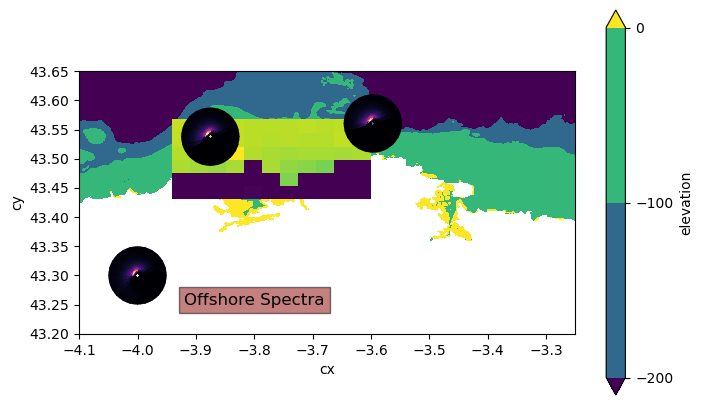

In [49]:
# from utils.plotting import plot_spectrum_in_coastline

# Load bathymetry to plot the spectra
bathy = xr.open_dataset(
    "http://geoocean.sci.unican.es/thredds/dodsC/geoceanWork/users/Gabriel/Binwaves/binwaves/data/bathymetry/bati_cantabria_100m.nc"
)
bathy["cx"], bathy["cy"] = convert_utm_to_lonlat(
    bathy.cx.values, bathy.cy.values, "SPAIN"
)

# Plot the spectrum along the coastline
plot_spectrum_in_coastline(
    bathy=bathy.elevation.T,
    reconstructed_onshore_spectra=reconstructed_onshore_spectra,
    reconstruction_kps=selected_kps,
    offshore_spectra=offshore_spectra,
)